In [1]:
import matplotlib
# Temporary compatibility patch for SHAP + Matplotlib 3.9+
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import mlflow
import mlflow.sklearn
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, f1_score, roc_curve,
    confusion_matrix, classification_report
)
from sklearn.calibration import calibration_curve

plt.rcParams["figure.dpi"] = 120
sns.set(style="whitegrid")
DATA_MODEL_PATH = "/work/siads_699_mads_capstone/data/models/workzone_features.csv"
df = pd.read_csv(DATA_MODEL_PATH)
print(df.head(5).to_markdown())
print(df.dtypes)

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
|    | road_event_id                   | road_name   |   duration_hr | vehicle_impact   |   latitude |   longitude |   crash_count |   avg_severity |   avg_distance_km |   avg_visibility_mi |   avg_precip_in |   avg_temp_F |   avg_wind_mph |   high_risk |
|---:|:--------------------------------|:------------|--------------:|:-----------------|-----------:|------------:|--------------:|---------------:|------------------:|--------------------:|----------------:|-------------:|---------------:|------------:|
|  0 | ELP_2022-01-27_00083+2024-04-02 | Americas    |       23.9997 | all-lanes-open   |    31.6766 |    -106.324 |           134 |              2 |          0.561889 |             9.77239 |       0.0735714 |       72.241 |        8.43016 |  

In [3]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(DATA_MODEL_PATH)
feature_cols = [
    "duration_hr",
    "avg_distance_km",
    "avg_visibility_mi",
    "avg_temp_F",
    "avg_wind_mph",
]
X = df[feature_cols].copy()
y = df["high_risk"].copy()
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Class balance (test):")
print(y_test.value_counts(normalize=True))


Train size: 1322 Test size: 331
Class balance (test):
high_risk
0    0.749245
1    0.250755
Name: proportion, dtype: float64


In [4]:

mlflow.set_tracking_uri("siads_699_mads_capstone/mlruns")
mlflow.set_experiment("WorkZone_XGBoost_Final")

client = mlflow.tracking.MlflowClient()
exp = client.get_experiment_by_name("WorkZone_XGBoost_Final")
runs = client.search_runs(exp.experiment_id, order_by=["attributes.start_time DESC"], max_results=1)
last_run = runs[0]
print("Loaded run_id:", last_run.info.run_id)

best_xgb = mlflow.sklearn.load_model(f"runs:/{last_run.info.run_id}/XGBoost_Final")
print("Loaded XGBoost_Final model from MLflow.")


/root/venv/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
Loaded run_id: d4b8d6d0d682465ba3a5ea5a320fd307



XGBoost — AUC: 0.999, F1: 0.965

Classification report (XGBoost):

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       248
           1       0.94      0.99      0.96        83

    accuracy                           0.98       331
   macro avg       0.97      0.98      0.98       331
weighted avg       0.98      0.98      0.98       331



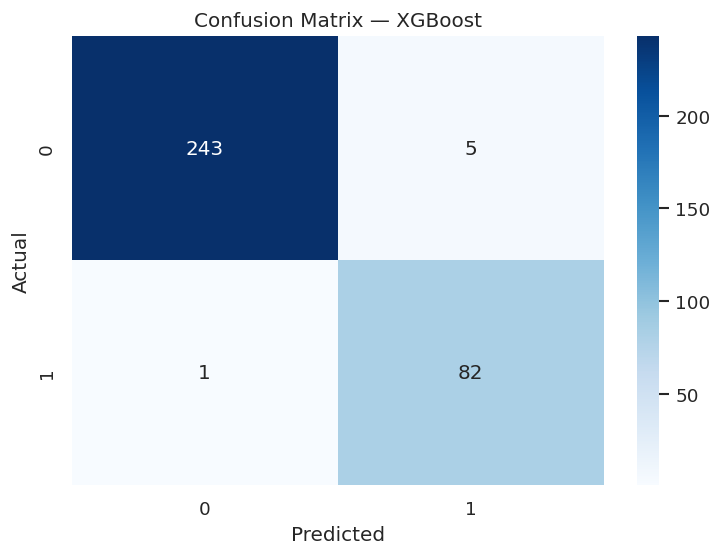

In [5]:
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_prob_xgb > 0.5).astype(int)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"XGBoost — AUC: {auc_xgb:.3f}, F1: {f1_xgb:.3f}")
print("\nClassification report (XGBoost):\n")
print(classification_report(y_test, y_pred_xgb))

#Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

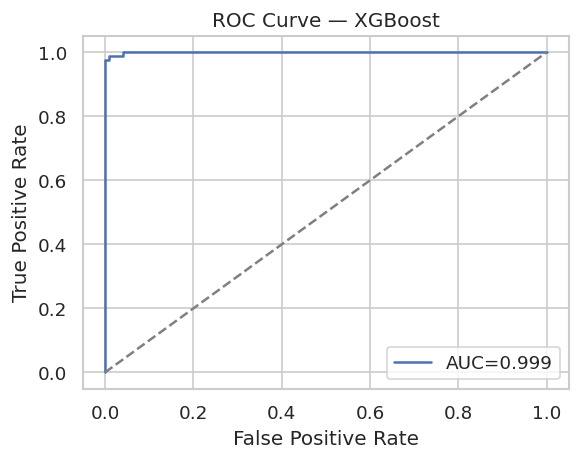

In [6]:
#ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc_xgb:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost")
plt.legend()
plt.tight_layout()
plt.show()

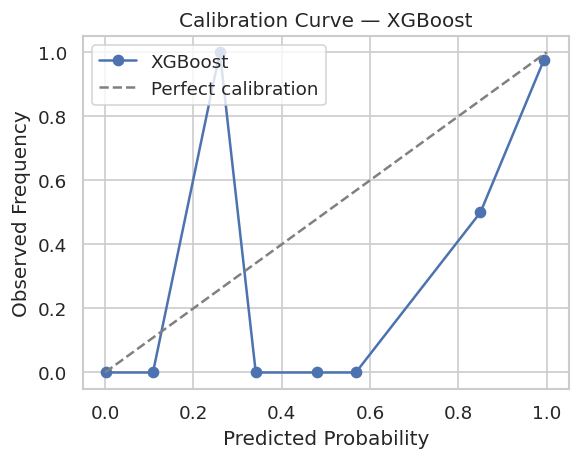

In [7]:
#Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob_xgb, n_bins=10, strategy="uniform")

plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, marker="o", label="XGBoost")
plt.plot([0,1], [0,1], "--", color="gray", label="Perfect calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve — XGBoost")
plt.legend()
plt.tight_layout()
plt.show()


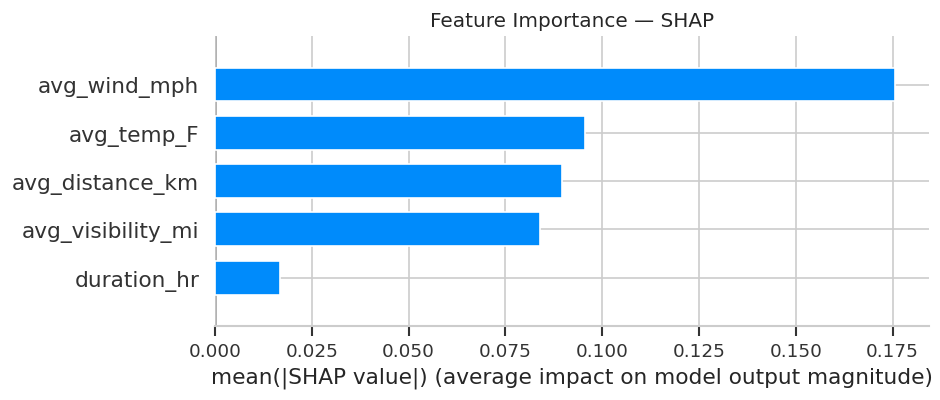

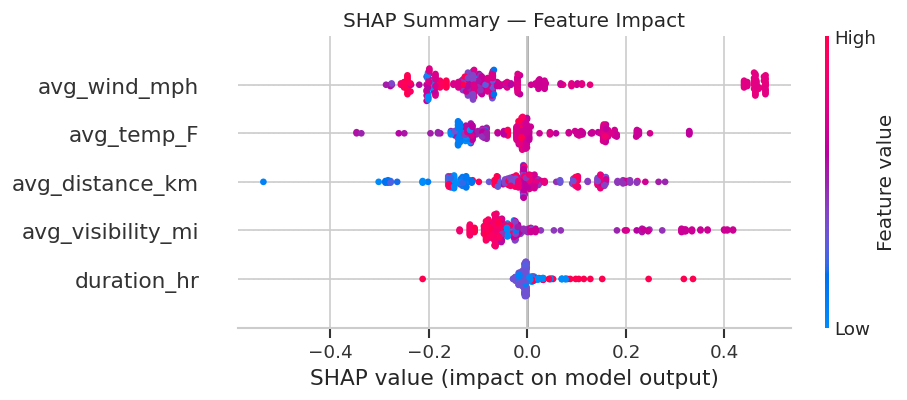

In [8]:
#SHAP
explainer = shap.Explainer(best_xgb.predict, X_test)
shap_values = explainer(X_test)

plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Feature Importance — SHAP")
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary — Feature Impact")
plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=609edc76-98cb-4265-b05f-b8bb14bd7d7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>